In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Mark Up phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

mark up phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2008-11-17    17.790001  23.793106 -99.509793 -20764000.0     2.0
2008-11-18    15.400000  22.501859 -98.846675 -32084400.0     2.0
2008-11-19    15.980000  21.498496 -94.911805 -25902800.0     2.0
2008-11-20    14.550000  20.429497 -99.036605 -31324000.0     1.0
2008-11-21    14.150000  19.463420 -99.684945 -38055900.0     2.0


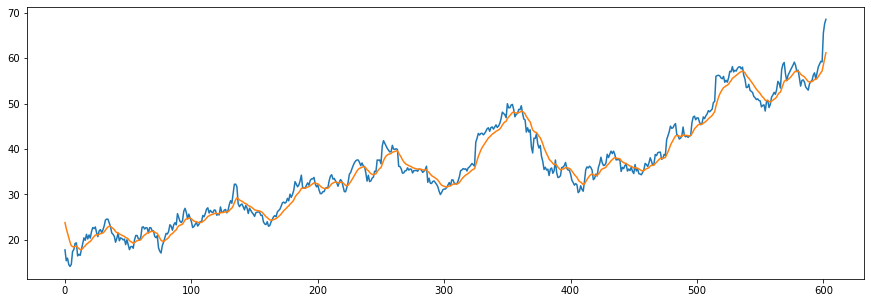

mark up phase data\10_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2006-01-17    20.655001  20.654687 -33.333333 -500723200.0     2.0
2006-01-18    20.514999  20.633197 -52.000173 -512297200.0     2.0
2006-01-19    20.410000  20.598859 -66.000112 -525203400.0     2.0
2006-01-20    20.465000  20.578265 -58.666738 -514295800.0     1.0
2006-01-23    20.045000  20.496224 -70.204110 -533267400.0     2.0


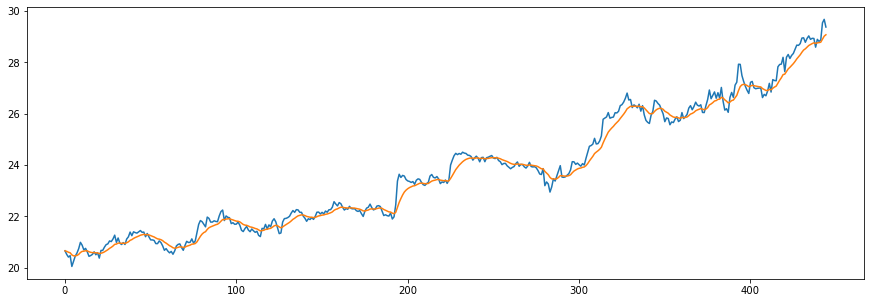

mark up phase data\11_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2011-09-19    62.049999  62.040598 -50.530081 -129442400.0     2.0
2011-09-20    60.560001  61.812814 -76.855114 -143029400.0     2.0
2011-09-21    60.389999  61.593920 -79.751333 -152659600.0     2.0
2011-09-22    60.790001  61.470240 -72.646507 -138309200.0     2.0
2011-09-23    60.919998  61.385587 -65.637902 -121968200.0     2.0


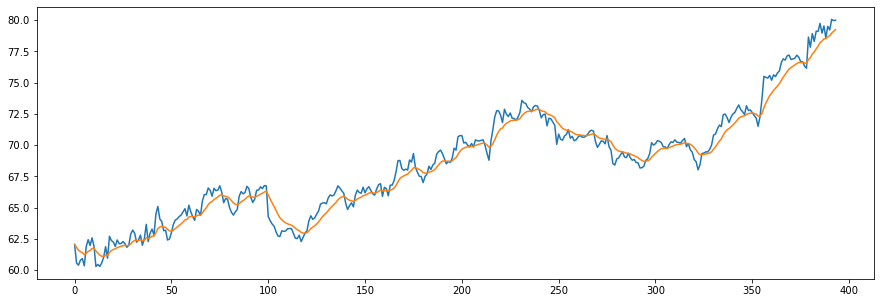

mark up phase data\1_acc_data.csv
            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2016-09-12   128.529999  131.714910 -97.877674  246447200.0     2.0
2016-09-13   130.119995  131.469539 -62.127252  252828300.0     2.0
2016-09-14   128.759995  131.052686 -70.623525  248275900.0     2.0
2016-09-15   127.669998  130.532272 -82.496784  244320500.0     2.0
2016-09-16   127.769997  130.107307 -81.209803  247782900.0     1.0


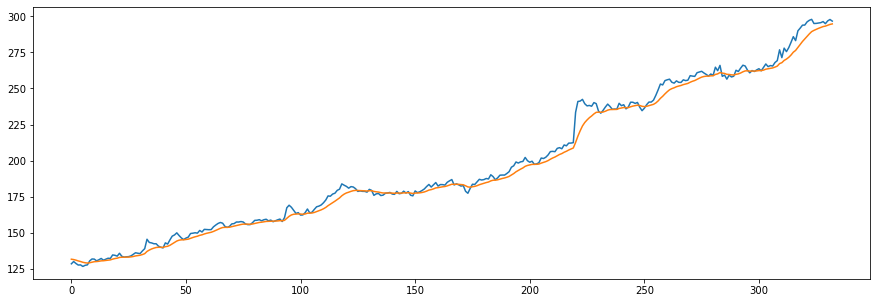

mark up phase data\2_acc_data.csv
            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2015-08-17   209.979996  210.306242 -25.639489  1.091620e+09     2.0
2015-08-18   206.220001  209.677590 -66.365130  1.086234e+09     2.0
2015-08-19   201.059998  208.351806 -94.906800  1.081106e+09     2.0
2015-08-20   201.619995  207.316143 -78.646789  1.086132e+09     2.0
2015-08-21   195.070007  205.432122 -99.123190  1.082167e+09     2.0


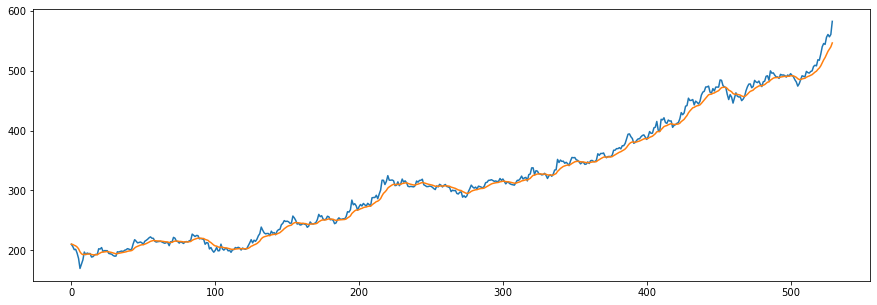

mark up phase data\3_acc_data.csv
            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2017-07-17   153.000000  155.694278 -80.508425  116165500.0     2.0
2017-07-18   152.839996  155.255158 -82.015049  113069000.0     2.0
2017-07-19   151.500000  154.677441 -94.529687  109812100.0     2.0
2017-07-20   151.240005  154.148605 -96.746304  105712100.0     2.0
2017-07-21   150.990005  153.662666 -98.949373  102504700.0     1.0


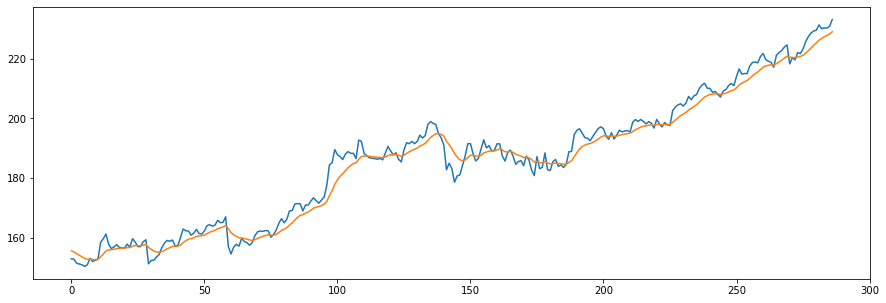

mark up phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2016-06-20    62.279999  63.332285 -72.509996 -2.241342e+09     2.0
2016-06-21    62.369999  63.184241 -70.717164 -2.229129e+09     2.0
2016-06-22    62.950001  63.148204 -58.248454 -2.217517e+09     2.0
2016-06-23    62.709999  63.080788 -62.757257 -2.230161e+09     0.0
2016-06-24    64.050003  63.229898 -35.185162 -2.213577e+09     2.0


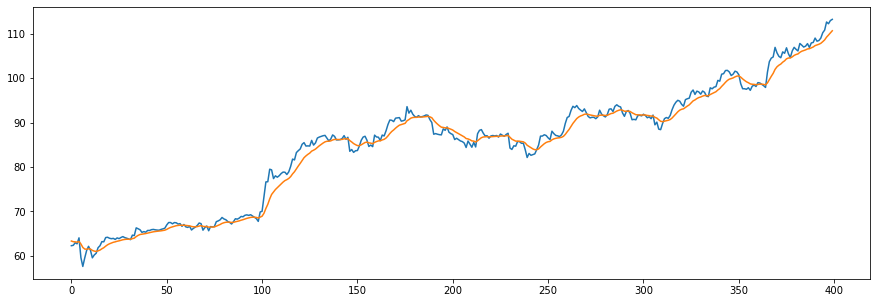

mark up phase data\5_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    91.419998  91.455093 -52.848110  -5093000.0     1.0
2019-01-23    90.440002  91.298925 -66.084726 -18611500.0     2.0
2019-01-24    94.839996  91.843705 -21.418921   4257500.0     2.0
2019-01-25    94.300003  92.221597 -28.785813  -7888900.0     2.0
2019-01-28    93.599998  92.433659 -38.335668 -18506900.0     2.0


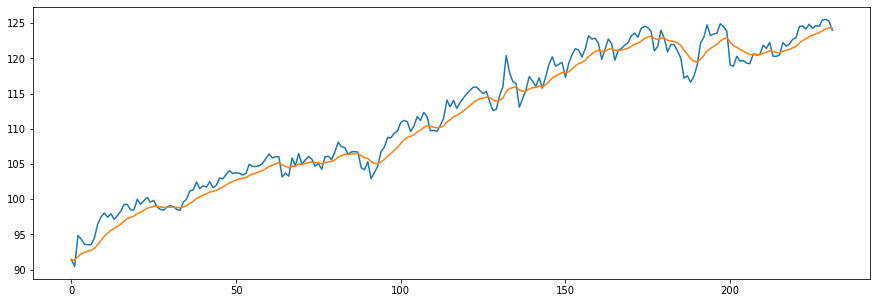

mark up phase data\6_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-04-22       11.000  11.129454 -63.157884  265234002.0     2.0
2013-04-23       10.900  11.094154 -73.684232  253872304.0     1.0
2013-04-24       10.750  11.041207 -89.473653  235528586.0     2.0
2013-04-25       11.000  11.034867 -63.157884  241232586.0     2.0
2013-04-26       10.975  11.025657 -65.789421  237776586.0     2.0


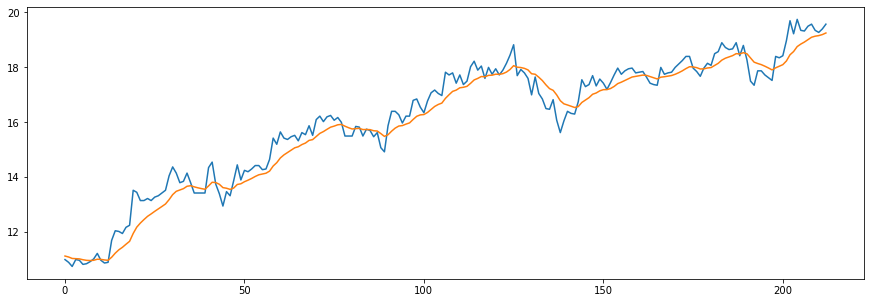

mark up phase data\7_acc_data.csv
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   114.040001  121.098552 -98.547847 -39707800.0     2.0
2020-01-23   113.900002  119.991082 -99.140747 -44778400.0     2.0
2020-01-24   115.529999  119.304762 -80.714281 -40136900.0     2.0
2020-01-27   114.320000  118.537875 -90.317449 -44475800.0     2.0
2020-01-28   115.779999  118.113587 -75.552172 -37696600.0     2.0


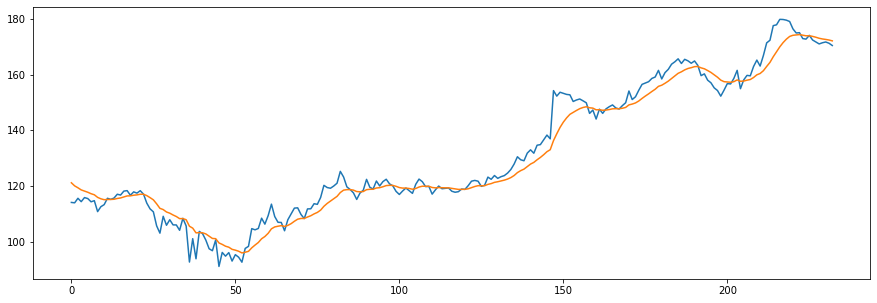

mark up phase data\8_acc_data.csv
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2016-10-31   123.580002  124.920987 -72.495976  70534500.0     2.0
2016-11-01   122.010002  124.473143 -94.018411  64863000.0     1.0
2016-11-02   119.889999  123.768044 -92.281854  57370400.0     2.0
2016-11-03   120.290001  123.232961 -87.807565  62216400.0     2.0
2016-11-04   120.180000  122.763274 -89.037997  57102900.0     2.0


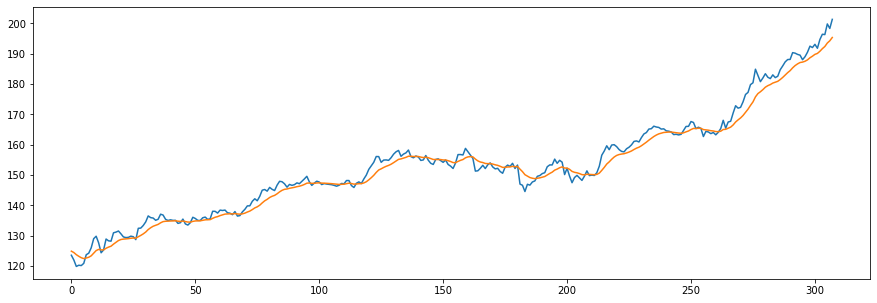

mark up phase data\9_acc_data.csv
            previous_1d     EMA_12    willr_14        OBV_7  labels
Date                                                               
2010-06-28    25.129999  25.907493 -100.000000  368525200.0     2.0
2010-06-29    25.540001  25.850956  -70.921898  392050600.0     2.0
2010-06-30    25.165001  25.745424  -92.281775  368548000.0     2.0
2010-07-01    25.059999  25.639974  -96.416922  346614200.0     1.0
2010-07-02    25.014999  25.543824  -84.487605  320583400.0     2.0


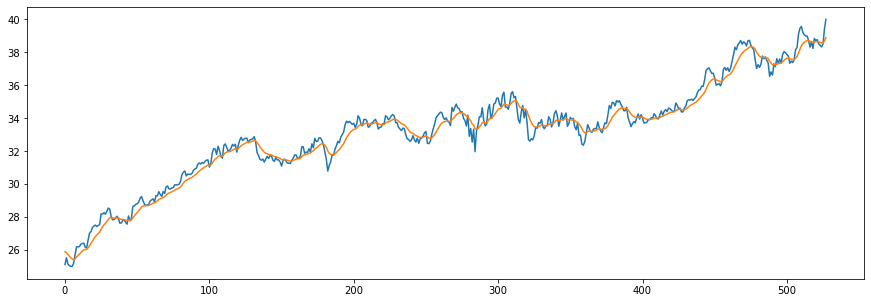

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('mark up phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4338, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4338, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 3973, 0.0: 184, 1.0: 181})

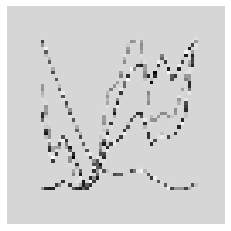

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.8684807256235825, 1: 7.977011494252873, 2: 0.36396056219844763}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/28 [>.............................] - ETA: 0s - loss: 0.6322 - accuracy: 0.6172 - mse: 5.6423 - weighted_accuracy: 0.2306 - weighted_mse: 5.0653WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
28/28 [==============================] - 1s 34ms/step - loss: 0.2403 - accuracy: 0.3352 - mse: 1.6883 - weighted_accuracy: 0.3619 - weighted_mse: 1.7483 - val_loss: 0.2256 - val_accuracy: 0.0415 - val_mse: 1.0242 - val_weighted_accuracy: 0.0415 - val_weighted_mse: 1.0242
Epoch 2/20
28/28 [==============================] - 0s 15ms/step - loss: 0.2060 - accuracy: 0.1804 - mse: 1.2168 - weighted_accuracy: 0.3369 - weighted_mse: 1.1910 - val_loss: 0.1993

7/7 [==============================] - 0s 14ms/step - loss: 0.2103 - accuracy: 0.0320 - mse: 0.9267 - weighted_accuracy: 0.0320 - weighted_mse: 0.9267
Test loss: 0.21028339862823486
Test accuracy: 0.031963471323251724


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 11
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 201
actual holds but predicted sell: 0
actual predicted holds: 0
Percentage buys correct: 3.1963470319634704%
Percentage sells correct: 0%
Percentage holds correct: 0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 44.95412844036697%
Percentage high sells correct: 0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864




Capital at the end of test period: $355.7316817269389
profit ga

29/29 [==============================] - 0s 7ms/step - loss: 0.2100 - accuracy: 0.0622 - mse: 0.9326 - weighted_accuracy: 0.0622 - weighted_mse: 0.9326
Test loss: 0.21004831790924072
Test accuracy: 0.062159214168787


number of predictions: 917
actual predicted buys: 46
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 40
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 820
actual holds but predicted sell: 0
actual predicted holds: 11
Percentage buys correct: 5.077262693156733%
Percentage sells correct: 0%
Percentage holds correct: 100.0%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 40.331491712707184%
Percentage high sells correct: 0%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.49212645240288966
Shares owned at the moment: 202
Cash capital at the moment: $0.31708037030648484




Capital at the end of test period: $3.99330

Epoch 20/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1885 - accuracy: 0.3245 - mse: 1.2237 - weighted_accuracy: 0.4713 - weighted_mse: 1.2093 - val_loss: 0.2000 - val_accuracy: 0.0634 - val_mse: 1.0129 - val_weighted_accuracy: 0.0634 - val_weighted_mse: 1.0129
Validation loss: 0.20004761219024658
Validation accuracy: 0.06336405873298645


accumulation phase data


8/8 [==============================] - 0s 4ms/step - loss: 0.2018 - accuracy: 0.0524 - mse: 1.0447 - weighted_accuracy: 0.0524 - weighted_mse: 1.0447
Test loss: 0.2018190175294876
Test accuracy: 0.052419353276491165


number of predictions: 248
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 111
actual holds but predicted sell: 117
actual predicted holds: 1
Percentage buys correct: 6.504065040650406%
Percentage sells correct: 3.225806

15/15 [==============================] - 0s 5ms/step - loss: 0.2020 - accuracy: 0.0745 - mse: 1.0484 - weighted_accuracy: 0.0745 - weighted_mse: 1.0484
Test loss: 0.2019769549369812
Test accuracy: 0.07446808367967606


number of predictions: 470
actual predicted buys: 17
actual buys but predicted sell: 7
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 16
actual sells but predicted hold: 0
actual holds but predicted buy: 227
actual holds but predicted sell: 197
actual predicted holds: 2
Percentage buys correct: 6.854838709677419%
Percentage sells correct: 7.2727272727272725%
Percentage holds correct: 100.0%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 43.95161290322581%
Percentage high sells correct: 46.118721461187214%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.5051713785101153
Shares owned at the moment: 197
Cash capital at the moment: $0.20756183919942828


Price increase from pr

9/9 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.0827 - mse: 1.0456 - weighted_accuracy: 0.0827 - weighted_mse: 1.0456
Test loss: 0.20374563336372375
Test accuracy: 0.08273380994796753


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 151
actual holds but predicted sell: 96
actual predicted holds: 2
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 100.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.07142857142857%
Percentage high sells correct: 43.925233644859816%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previ

Price increase from previously bought: -5.6547191105067895%
Share price: $0.40332497171848036
Shares owned at the moment: 0
Cash capital at the moment: $1060.1030300792743


Share price: $0.4102254098188045
Shares owned at the moment: 2577
Cash capital at the moment: $0.044984053181678973


Price increase from previously bought: 20.834242737332985%
Share price: $0.49705592258121767
Shares owned at the moment: 0
Cash capital at the moment: $1277.4355854856271


Share price: $0.4803798638387673
Shares owned at the moment: 2651
Cash capital at the moment: $0.4464771467044102


Price increase from previously bought: 8.043883515060092%
Share price: $0.5204483684321803
Shares owned at the moment: 0
Cash capital at the moment: $1376.360903142452


Share price: $0.7471507558725743
Shares owned at the moment: 1837
Cash capital at the moment: $0.07054577355347647


Price increase from previously bought: 6.332645452186192%
Share price: $0.7966499434369607
Shares owned at the moment: 0
Cash capita

29/29 [==============================] - 0s 5ms/step - loss: 0.2021 - accuracy: 0.0774 - mse: 1.0402 - weighted_accuracy: 0.0774 - weighted_mse: 1.0402
Test loss: 0.2021465301513672
Test accuracy: 0.07742638885974884


number of predictions: 917
actual predicted buys: 38
actual buys but predicted sell: 8
actual buys but predicted hold: 0
actual sells but predicted buy: 11
actual predicted sells: 28
actual sells but predicted hold: 1
actual holds but predicted buy: 452
actual holds but predicted sell: 374
actual predicted holds: 5
Percentage buys correct: 7.584830339321357%
Percentage sells correct: 6.829268292682927%
Percentage holds correct: 83.33333333333333%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 46.6%
Percentage high sells correct: 43.65853658536585%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


Price increase

Epoch 1/20
28/28 [==============================] - 1s 20ms/step - loss: 0.1887 - accuracy: 0.3294 - mse: 1.2242 - weighted_accuracy: 0.4730 - weighted_mse: 1.2132 - val_loss: 0.1901 - val_accuracy: 0.3836 - val_mse: 1.0725 - val_weighted_accuracy: 0.3836 - val_weighted_mse: 1.0725
Epoch 2/20
28/28 [==============================] - 0s 16ms/step - loss: 0.1884 - accuracy: 0.3288 - mse: 1.2545 - weighted_accuracy: 0.4641 - weighted_mse: 1.2395 - val_loss: 0.2027 - val_accuracy: 0.0611 - val_mse: 1.0582 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 1.0582
Epoch 3/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1882 - accuracy: 0.3029 - mse: 1.2402 - weighted_accuracy: 0.4591 - weighted_mse: 1.2285 - val_loss: 0.1999 - val_accuracy: 0.0991 - val_mse: 1.0093 - val_weighted_accuracy: 0.0991 - val_weighted_mse: 1.0093
Epoch 4/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1855 - accuracy: 0.3110 - mse: 1.2275 - weighted_accuracy: 0.4794 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.0913 - mse: 1.1461 - weighted_accuracy: 0.0913 - weighted_mse: 1.1461
Test loss: 0.20506100356578827
Test accuracy: 0.09132420271635056


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 118
actual holds but predicted sell: 78
actual predicted holds: 5
Percentage buys correct: 5.511811023622047%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 83.33333333333333%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.17460317460318%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Price increase from

9/9 [==============================] - 0s 5ms/step - loss: 0.2089 - accuracy: 0.1187 - mse: 1.1843 - weighted_accuracy: 0.1187 - weighted_mse: 1.1843
Test loss: 0.2088921219110489
Test accuracy: 0.11870503425598145


number of predictions: 278
actual predicted buys: 15
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 164
actual holds but predicted sell: 76
actual predicted holds: 9
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 10.588235294117647%
Percentage holds correct: 90.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.30769230769231%
Percentage high sells correct: 48.23529411764706%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previously 

3         -97.604141  


bull phase data


7/7 [==============================] - 0s 4ms/step - loss: 0.2009 - accuracy: 0.1106 - mse: 1.1185 - weighted_accuracy: 0.1106 - weighted_mse: 1.1185
Test loss: 0.20087313652038574
Test accuracy: 0.11057692021131516


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 69
actual holds but predicted sell: 111
actual predicted holds: 9
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 45.56962025316456%
Percentage high sells correct: 47.45762711864407%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.0134144

5         -91.884658  


full cycle data


29/29 [==============================] - 0s 5ms/step - loss: 0.2066 - accuracy: 0.1156 - mse: 1.1737 - weighted_accuracy: 0.1156 - weighted_mse: 1.1737
Test loss: 0.20660704374313354
Test accuracy: 0.11559432744979858


number of predictions: 917
actual predicted buys: 41
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 29
actual sells but predicted hold: 3
actual holds but predicted buy: 486
actual holds but predicted sell: 309
actual predicted holds: 36
Percentage buys correct: 7.663551401869159%
Percentage sells correct: 8.454810495626822%
Percentage holds correct: 92.3076923076923%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.19101123595506%
Percentage high sells correct: 48.68804664723032%
Percentage mid holds correct: 89.74358974358974%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash cap

Epoch 1/20
28/28 [==============================] - 1s 18ms/step - loss: 0.1778 - accuracy: 0.2885 - mse: 1.2972 - weighted_accuracy: 0.5213 - weighted_mse: 1.2709 - val_loss: 0.2020 - val_accuracy: 0.1855 - val_mse: 1.0675 - val_weighted_accuracy: 0.1855 - val_weighted_mse: 1.0675
Epoch 2/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1756 - accuracy: 0.2945 - mse: 1.3235 - weighted_accuracy: 0.5299 - weighted_mse: 1.3012 - val_loss: 0.1962 - val_accuracy: 0.2177 - val_mse: 1.0707 - val_weighted_accuracy: 0.2177 - val_weighted_mse: 1.0707
Epoch 3/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1702 - accuracy: 0.2827 - mse: 1.3134 - weighted_accuracy: 0.5564 - weighted_mse: 1.3093 - val_loss: 0.1963 - val_accuracy: 0.1233 - val_mse: 1.0635 - val_weighted_accuracy: 0.1233 - val_weighted_mse: 1.0635
Epoch 4/20
28/28 [==============================] - 0s 16ms/step - loss: 0.1710 - accuracy: 0.3061 - mse: 1.3193 - weighted_accuracy: 0.5647 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.3196 - mse: 1.2188 - weighted_accuracy: 0.3196 - weighted_mse: 1.2188
Test loss: 0.19161315262317657
Test accuracy: 0.31963470578193665


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 79
actual holds but predicted sell: 66
actual predicted holds: 56
Percentage buys correct: 8.045977011494253%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 94.91525423728814%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.02298850574713%
Percentage high sells correct: 53.42465753424658%
Percentage mid holds correct: 93.10344827586206%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Price 

9/9 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.2662 - mse: 1.2497 - weighted_accuracy: 0.2662 - weighted_mse: 1.2497
Test loss: 0.19649522006511688
Test accuracy: 0.26618704199790955


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 124
actual holds but predicted sell: 72
actual predicted holds: 53
Percentage buys correct: 9.285714285714286%
Percentage sells correct: 10.0%
Percentage holds correct: 91.37931034482759%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.142857142857146%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at the moment: $0.029202429113055928


Price increase from previo

7/7 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.3125 - mse: 1.2211 - weighted_accuracy: 0.3125 - weighted_mse: 1.2211
Test loss: 0.1869356483221054
Test accuracy: 0.3125


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 40
actual holds but predicted sell: 95
actual predicted holds: 54
Percentage buys correct: 10.638297872340425%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 91.52542372881356%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.57446808510638%
Percentage high sells correct: 49.504950495049506%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.1503089080399258
Shares owned at the moment: 663
Cash capital at the moment: $0.07114325294539015


Price increase fro

Cash capital at the moment: $67.99007501865844


Share price: $0.5235268358699757
Shares owned at the moment: 129
Cash capital at the moment: $0.26939204640670766


Price increase from previously bought: -3.2725836800477803%
Share price: $0.5077865655293406
Shares owned at the moment: 0
Cash capital at the moment: $65.59372171557011


Share price: $0.5122135282900707
Shares owned at the moment: 127
Cash capital at the moment: $0.36371304797582127


Price increase from previously bought: 2.3114673028804544%
Share price: $0.5254943227528489
Shares owned at the moment: 0
Cash capital at the moment: $66.9179631453662


Share price: $0.4581062786295801
Shares owned at the moment: 145
Cash capital at the moment: $0.30988286547353994


Price increase from previously bought: -12.802472377122676%
Share price: $0.40055585655950143
Shares owned at the moment: 0
Cash capital at the moment: $58.23076041879815


Share price: $0.42269057654373976
Shares owned at the moment: 137
Cash capital at the mo

29/29 [==============================] - 0s 4ms/step - loss: 0.1964 - accuracy: 0.2628 - mse: 1.2502 - weighted_accuracy: 0.2628 - weighted_mse: 1.2502
Test loss: 0.19641408324241638
Test accuracy: 0.2628135085105896


number of predictions: 917
actual predicted buys: 35
actual buys but predicted sell: 5
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 30
actual sells but predicted hold: 9
actual holds but predicted buy: 357
actual holds but predicted sell: 298
actual predicted holds: 176
Percentage buys correct: 8.9058524173028%
Percentage sells correct: 9.00900900900901%
Percentage holds correct: 92.14659685863874%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 50.765306122448976%
Percentage high sells correct: 52.552552552552555%
Percentage mid holds correct: 85.86387434554973%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


P

Epoch 1/20
28/28 [==============================] - 1s 18ms/step - loss: 0.1568 - accuracy: 0.3461 - mse: 1.4030 - weighted_accuracy: 0.5990 - weighted_mse: 1.3919 - val_loss: 0.1914 - val_accuracy: 0.3560 - val_mse: 1.1877 - val_weighted_accuracy: 0.3560 - val_weighted_mse: 1.1877
Epoch 2/20
28/28 [==============================] - 0s 16ms/step - loss: 0.1531 - accuracy: 0.3562 - mse: 1.3869 - weighted_accuracy: 0.6114 - weighted_mse: 1.3965 - val_loss: 0.2014 - val_accuracy: 0.1982 - val_mse: 1.1726 - val_weighted_accuracy: 0.1982 - val_weighted_mse: 1.1726
Epoch 3/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1514 - accuracy: 0.3086 - mse: 1.4534 - weighted_accuracy: 0.6091 - weighted_mse: 1.4685 - val_loss: 0.1947 - val_accuracy: 0.2258 - val_mse: 1.2887 - val_weighted_accuracy: 0.2258 - val_weighted_mse: 1.2887
Epoch 4/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1496 - accuracy: 0.3110 - mse: 1.5368 - weighted_accuracy: 0.6295 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1864 - accuracy: 0.3653 - mse: 1.4113 - weighted_accuracy: 0.3653 - weighted_mse: 1.4113
Test loss: 0.1864376664161682
Test accuracy: 0.3652968108654022


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 66
actual holds but predicted sell: 69
actual predicted holds: 66
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 94.28571428571429%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.388888888888886%
Percentage high sells correct: 51.94805194805195%
Percentage mid holds correct: 91.30434782608695%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price 

9/9 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.3777 - mse: 1.4081 - weighted_accuracy: 0.3777 - weighted_mse: 1.4081
Test loss: 0.18507342040538788
Test accuracy: 0.3776978552341461


number of predictions: 278
actual predicted buys: 11
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 99
actual holds but predicted sell: 64
actual predicted holds: 86
Percentage buys correct: 9.821428571428571%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 92.47311827956989%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.642857142857146%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 84.94623655913979%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at the moment: $0.029202429113055928


P

7/7 [==============================] - 0s 4ms/step - loss: 0.1914 - accuracy: 0.3413 - mse: 1.4307 - weighted_accuracy: 0.3413 - weighted_mse: 1.4307
Test loss: 0.19142664968967438
Test accuracy: 0.3413461446762085


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 29
actual holds but predicted sell: 99
actual predicted holds: 61
Percentage buys correct: 13.88888888888889%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 91.04477611940298%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 82.08955223880596%


Capital: 100
Share price: $0.1503089080399258
Shares owned at the moment: 663
Cash capital at the moment: $0.07114325294539015


Price

29/29 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.3228 - mse: 1.4395 - weighted_accuracy: 0.3228 - weighted_mse: 1.4395
Test loss: 0.1916397362947464
Test accuracy: 0.32279172539711


number of predictions: 917
actual predicted buys: 28
actual buys but predicted sell: 5
actual buys but predicted hold: 13
actual sells but predicted buy: 1
actual predicted sells: 28
actual sells but predicted hold: 11
actual holds but predicted buy: 297
actual holds but predicted sell: 294
actual predicted holds: 240
Percentage buys correct: 8.588957055214724%
Percentage sells correct: 8.562691131498472%
Percentage holds correct: 90.9090909090909%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.38461538461539%
Percentage high sells correct: 52.293577981651374%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Cash capital at the moment: $40.712437434206734


Share price: $0.7891016746599171
Shares owned at the moment: 51
Cash capital at the moment: $0.35758051667991


Price increase from previously bought: -8.26703628061739%
Share price: $0.7258569853953656
Shares owned at the moment: 0
Cash capital at the moment: $37.27448532964185


Share price: $0.7231072391002611
Shares owned at the moment: 51
Cash capital at the moment: $0.29460034524472434


Price increase from previously bought: 1.621892478239606%
Share price: $0.7368560579886416
Shares owned at the moment: 0
Cash capital at the moment: $37.770915240532545


Share price: $0.7350229229295249
Shares owned at the moment: 51
Cash capital at the moment: $0.18165920618591258


Price increase from previously bought: -1.5178533426191243%
Share price: $0.7258569853953656
Shares owned at the moment: 0
Cash capital at the moment: $37.09856401914785


Share price: $0.7075251977399057
Shares owned at the moment: 52
Cash capital at the moment: $0.

Epoch 1/20
28/28 [==============================] - 1s 19ms/step - loss: 0.1375 - accuracy: 0.4303 - mse: 1.6168 - weighted_accuracy: 0.6902 - weighted_mse: 1.6754 - val_loss: 0.1709 - val_accuracy: 0.5150 - val_mse: 1.3582 - val_weighted_accuracy: 0.5150 - val_weighted_mse: 1.3582
Epoch 2/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1321 - accuracy: 0.4308 - mse: 1.6574 - weighted_accuracy: 0.6949 - weighted_mse: 1.7614 - val_loss: 0.1879 - val_accuracy: 0.3675 - val_mse: 1.3877 - val_weighted_accuracy: 0.3675 - val_weighted_mse: 1.3877
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1334 - accuracy: 0.4251 - mse: 1.6578 - weighted_accuracy: 0.6754 - weighted_mse: 1.7518 - val_loss: 0.1700 - val_accuracy: 0.4758 - val_mse: 1.4377 - val_weighted_accuracy: 0.4758 - val_weighted_mse: 1.4377
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.1305 - accuracy: 0.4628 - mse: 1.6711 - weighted_accuracy: 0.7131 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1705 - accuracy: 0.5068 - mse: 1.4722 - weighted_accuracy: 0.5068 - weighted_mse: 1.4722
Test loss: 0.17049641907215118
Test accuracy: 0.5068492889404297


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 63
actual holds but predicted sell: 38
actual predicted holds: 100
Percentage buys correct: 7.352941176470588%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 93.45794392523365%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.529411764705884%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 89.62264150943396%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


Pr

9/9 [==============================] - 0s 4ms/step - loss: 0.1677 - accuracy: 0.5036 - mse: 1.4646 - weighted_accuracy: 0.5036 - weighted_mse: 1.4646
Test loss: 0.16772039234638214
Test accuracy: 0.5035971403121948


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 89
actual holds but predicted sell: 31
actual predicted holds: 129
Percentage buys correct: 9.900990099009901%
Percentage sells correct: 3.125%
Percentage holds correct: 88.96551724137932%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.56435643564357%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 81.94444444444444%


Capital: 100
Share price: $0.9164924855214011
Shares owned at the moment: 108
Cash capital at the moment: $0.746613295488828


Price increase from previou

19/19 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.4807 - mse: 1.5102 - weighted_accuracy: 0.4807 - weighted_mse: 1.5102
Test loss: 0.17803440988063812
Test accuracy: 0.48067227005958557


number of predictions: 595
actual predicted buys: 15
actual buys but predicted sell: 2
actual buys but predicted hold: 15
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 16
actual holds but predicted buy: 162
actual holds but predicted sell: 112
actual predicted holds: 262
Percentage buys correct: 8.379888268156424%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 89.419795221843%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 53.93258426966292%
Percentage high sells correct: 52.84552845528455%
Percentage mid holds correct: 82.93515358361775%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867



29/29 [==============================] - 0s 3ms/step - loss: 0.1740 - accuracy: 0.4820 - mse: 1.4937 - weighted_accuracy: 0.4820 - weighted_mse: 1.4937
Test loss: 0.17400436103343964
Test accuracy: 0.4820065498352051


number of predictions: 917
actual predicted buys: 31
actual buys but predicted sell: 2
actual buys but predicted hold: 13
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 28
actual holds but predicted buy: 272
actual holds but predicted sell: 158
actual predicted holds: 401
Percentage buys correct: 10.163934426229508%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.72398190045249%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.61842105263158%
Percentage high sells correct: 54.11764705882353%
Percentage mid holds correct: 83.03167420814479%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.290245031625957

6         -96.006693  



RUNNING EPOCHS 120 - 140



Epoch 1/20
28/28 [==============================] - 0s 18ms/step - loss: 0.1182 - accuracy: 0.5357 - mse: 1.7156 - weighted_accuracy: 0.7289 - weighted_mse: 1.9276 - val_loss: 0.1605 - val_accuracy: 0.6014 - val_mse: 1.4927 - val_weighted_accuracy: 0.6014 - val_weighted_mse: 1.4927
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1189 - accuracy: 0.5441 - mse: 1.7509 - weighted_accuracy: 0.7166 - weighted_mse: 2.0475 - val_loss: 0.1711 - val_accuracy: 0.5311 - val_mse: 1.5135 - val_weighted_accuracy: 0.5311 - val_weighted_mse: 1.5135
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1185 - accuracy: 0.5559 - mse: 1.7736 - weighted_accuracy: 0.7428 - weighted_mse: 2.0227 - val_loss: 0.1607 - val_accuracy: 0.5899 - val_mse: 1.4977 - val_weighted_accuracy: 0.5899 - val_weighted_mse: 1.4977
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1164 - accuracy: 0.543

7/7 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.5890 - mse: 1.5700 - weighted_accuracy: 0.5890 - weighted_mse: 1.5700
Test loss: 0.15498754382133484
Test accuracy: 0.5890411138534546


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 48
actual holds but predicted sell: 33
actual predicted holds: 120
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 93.02325581395348%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.16981132075472%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 88.28125%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


Price increas

9/9 [==============================] - 0s 4ms/step - loss: 0.1491 - accuracy: 0.6439 - mse: 1.5365 - weighted_accuracy: 0.6439 - weighted_mse: 1.5365
Test loss: 0.14905260503292084
Test accuracy: 0.6438848972320557


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 54
actual holds but predicted sell: 26
actual predicted holds: 169
Percentage buys correct: 14.0625%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 90.37433155080214%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 46.875%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 83.42245989304813%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at the moment: $0.029202429113055928


Price increase from pr

19/19 [==============================] - 0s 4ms/step - loss: 0.1642 - accuracy: 0.5496 - mse: 1.6129 - weighted_accuracy: 0.5496 - weighted_mse: 1.6129
Test loss: 0.1642226278781891
Test accuracy: 0.5495798587799072


number of predictions: 595
actual predicted buys: 10
actual buys but predicted sell: 2
actual buys but predicted hold: 20
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 16
actual holds but predicted buy: 125
actual holds but predicted sell: 103
actual predicted holds: 308
Percentage buys correct: 7.299270072992701%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 89.53488372093024%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 54.01459854014598%
Percentage high sells correct: 57.01754385964912%
Percentage mid holds correct: 82.79883381924198%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867



29/29 [==============================] - 0s 4ms/step - loss: 0.1590 - accuracy: 0.5965 - mse: 1.5930 - weighted_accuracy: 0.5965 - weighted_mse: 1.5930
Test loss: 0.15902632474899292
Test accuracy: 0.5965103507041931


number of predictions: 917
actual predicted buys: 20
actual buys but predicted sell: 3
actual buys but predicted hold: 23
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 29
actual holds but predicted buy: 176
actual holds but predicted sell: 137
actual predicted holds: 518
Percentage buys correct: 10.1010101010101%
Percentage sells correct: 6.040268456375839%
Percentage holds correct: 90.87719298245614%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 56.34517766497462%
Percentage high sells correct: 55.033557046979865%
Percentage mid holds correct: 84.03508771929825%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.0992395758376716

Epoch 1/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1103 - accuracy: 0.6233 - mse: 1.8181 - weighted_accuracy: 0.7583 - weighted_mse: 2.1231 - val_loss: 0.1514 - val_accuracy: 0.6740 - val_mse: 1.5082 - val_weighted_accuracy: 0.6740 - val_weighted_mse: 1.5082
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1081 - accuracy: 0.6075 - mse: 1.8289 - weighted_accuracy: 0.7593 - weighted_mse: 2.2372 - val_loss: 0.1515 - val_accuracy: 0.6705 - val_mse: 1.5096 - val_weighted_accuracy: 0.6705 - val_weighted_mse: 1.5096
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1021 - accuracy: 0.6055 - mse: 1.9037 - weighted_accuracy: 0.7781 - weighted_mse: 2.3844 - val_loss: 0.1480 - val_accuracy: 0.6751 - val_mse: 1.5410 - val_weighted_accuracy: 0.6751 - val_weighted_mse: 1.5410
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1050 - accuracy: 0.6130 - mse: 1.8704 - weighted_accuracy: 0.7678 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.7854 - mse: 1.7188 - weighted_accuracy: 0.7854 - weighted_mse: 1.7188
Test loss: 0.12094715237617493
Test accuracy: 0.7853881120681763


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 12
actual predicted holds: 165
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 25.0%
Percentage holds correct: 93.75%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.42857142857143%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previously bought: 177

9/9 [==============================] - 0s 5ms/step - loss: 0.1184 - accuracy: 0.8022 - mse: 1.6960 - weighted_accuracy: 0.8022 - weighted_mse: 1.6960
Test loss: 0.11839401721954346
Test accuracy: 0.8021582961082458


number of predictions: 278
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 25
actual holds but predicted sell: 7
actual predicted holds: 217
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 12.5%
Percentage holds correct: 90.41666666666667%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 50.0%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 84.10041841004184%


Capital: 100
Share price: $0.8232401149455993
Shares owned at the moment: 121
Cash capital at the moment: $0.11401294333433043


Price increase from previously bought: 9.

29/29 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.7579 - mse: 1.7476 - weighted_accuracy: 0.7579 - weighted_mse: 1.7476
Test loss: 0.12742184102535248
Test accuracy: 0.7579061985015869


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 2
actual buys but predicted hold: 30
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 36
actual holds but predicted buy: 88
actual holds but predicted sell: 66
actual predicted holds: 677
Percentage buys correct: 13.72549019607843%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 91.1170928667564%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 59.40594059405941%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 84.65679676985195%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Epoch 1/20
28/28 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.6700 - mse: 2.0228 - weighted_accuracy: 0.7799 - weighted_mse: 2.6182 - val_loss: 0.1313 - val_accuracy: 0.7419 - val_mse: 1.6947 - val_weighted_accuracy: 0.7419 - val_weighted_mse: 1.6947
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0920 - accuracy: 0.6821 - mse: 2.0772 - weighted_accuracy: 0.7887 - weighted_mse: 2.7176 - val_loss: 0.1280 - val_accuracy: 0.7558 - val_mse: 1.6111 - val_weighted_accuracy: 0.7558 - val_weighted_mse: 1.6111
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0895 - accuracy: 0.6890 - mse: 2.2309 - weighted_accuracy: 0.8172 - weighted_mse: 2.9542 - val_loss: 0.1298 - val_accuracy: 0.7431 - val_mse: 1.6763 - val_weighted_accuracy: 0.7431 - val_weighted_mse: 1.6763
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0918 - accuracy: 0.6968 - mse: 2.0876 - weighted_accuracy: 0.7896 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.8128 - mse: 1.7595 - weighted_accuracy: 0.8128 - weighted_mse: 1.7595
Test loss: 0.11072220653295517
Test accuracy: 0.8127853870391846


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 7
actual predicted holds: 172
Percentage buys correct: 12.0%
Percentage sells correct: 30.0%
Percentage holds correct: 93.47826086956522%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.88524590163935%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previously bought: 177.37515376033195

9/9 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.8129 - mse: 1.7801 - weighted_accuracy: 0.8129 - weighted_mse: 1.7801
Test loss: 0.11018376052379608
Test accuracy: 0.8129496574401855


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 25
actual holds but predicted sell: 5
actual predicted holds: 219
Percentage buys correct: 19.35483870967742%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 90.87136929460581%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.38709677419355%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.9340506072790936
Shares owned at the moment: 106
Cash capital at the moment: $0.7183598763942172


Price increase f

29/29 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.7797 - mse: 1.8079 - weighted_accuracy: 0.7797 - weighted_mse: 1.8079
Test loss: 0.11928211152553558
Test accuracy: 0.7797164916992188


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 38
actual holds but predicted buy: 90
actual holds but predicted sell: 42
actual predicted holds: 699
Percentage buys correct: 13.461538461538462%
Percentage sells correct: 4.444444444444445%
Percentage holds correct: 91.015625%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 60.19417475728155%
Percentage high sells correct: 64.44444444444444%
Percentage mid holds correct: 84.89583333333333%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Price

Epoch 1/20
28/28 [==============================] - 0s 13ms/step - loss: 0.0854 - accuracy: 0.7251 - mse: 2.2092 - weighted_accuracy: 0.8020 - weighted_mse: 2.9337 - val_loss: 0.1208 - val_accuracy: 0.7892 - val_mse: 1.7329 - val_weighted_accuracy: 0.7892 - val_weighted_mse: 1.7329
Epoch 2/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0823 - accuracy: 0.7049 - mse: 2.1986 - weighted_accuracy: 0.8079 - weighted_mse: 3.1965 - val_loss: 0.1124 - val_accuracy: 0.8122 - val_mse: 1.7583 - val_weighted_accuracy: 0.8122 - val_weighted_mse: 1.7583
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0780 - accuracy: 0.7360 - mse: 2.3445 - weighted_accuracy: 0.8386 - weighted_mse: 3.1744 - val_loss: 0.1130 - val_accuracy: 0.8122 - val_mse: 1.9352 - val_weighted_accuracy: 0.8122 - val_weighted_mse: 1.9352
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0778 - accuracy: 0.7291 - mse: 2.4519 - weighted_accuracy: 0.8231 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.8402 - mse: 1.8317 - weighted_accuracy: 0.8402 - weighted_mse: 1.8317
Test loss: 0.10276943445205688
Test accuracy: 0.8401826620101929


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 18
actual holds but predicted sell: 4
actual predicted holds: 179
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 93.22916666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 86.91099476439791%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Pri

9/9 [==============================] - 0s 2ms/step - loss: 0.1029 - accuracy: 0.8345 - mse: 1.8466 - weighted_accuracy: 0.8345 - weighted_mse: 1.8466
Test loss: 0.10286694765090942
Test accuracy: 0.8345323801040649


number of predictions: 278
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 15
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 13
actual holds but predicted buy: 15
actual holds but predicted sell: 3
actual predicted holds: 231
Percentage buys correct: 6.25%
Percentage sells correct: 0.0%
Percentage holds correct: 89.1891891891892%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.75%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 82.94573643410853%


Capital: 100
Share price: $0.9340506072790936
Shares owned at the moment: 106
Cash capital at the moment: $0.7183598763942172


Price increase from previously bought: -3.7

29/29 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.8059 - mse: 1.8867 - weighted_accuracy: 0.8059 - weighted_mse: 1.8867
Test loss: 0.1113603487610817
Test accuracy: 0.8058887720108032


number of predictions: 917
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 36
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 37
actual holds but predicted buy: 65
actual holds but predicted sell: 40
actual predicted holds: 726
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 90.86357947434293%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 58.108108108108105%
Percentage high sells correct: 72.09302325581395%
Percentage mid holds correct: 84.73091364205257%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0     82.557937
1    255.731682
2    -35.065241
3    -97.604141
4    678.794088
5    -91.884658
6    -96.006693
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


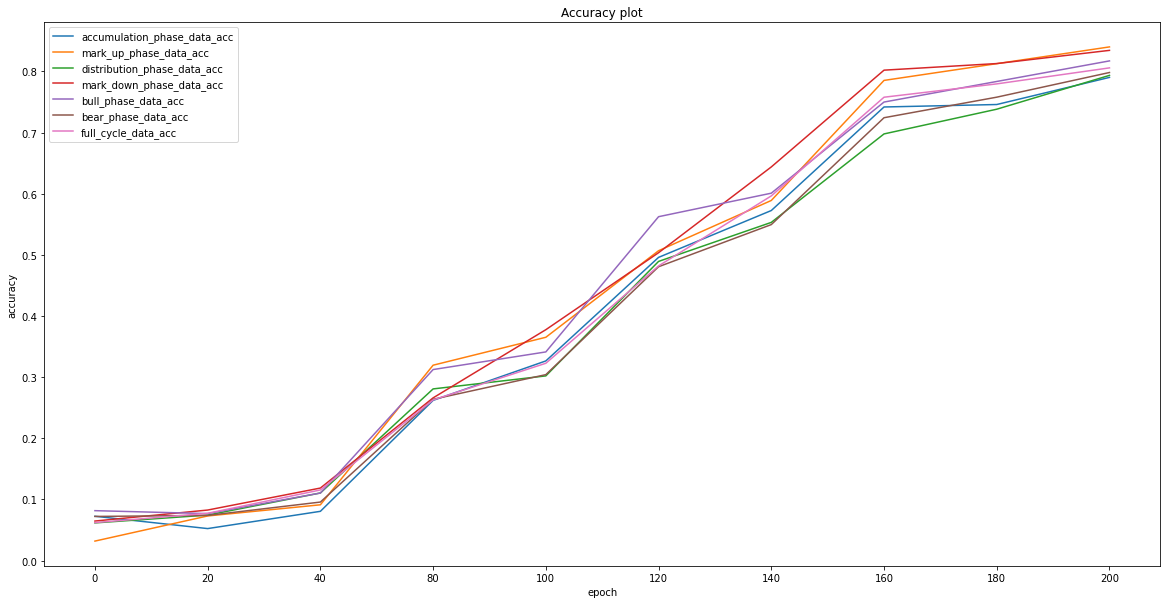

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

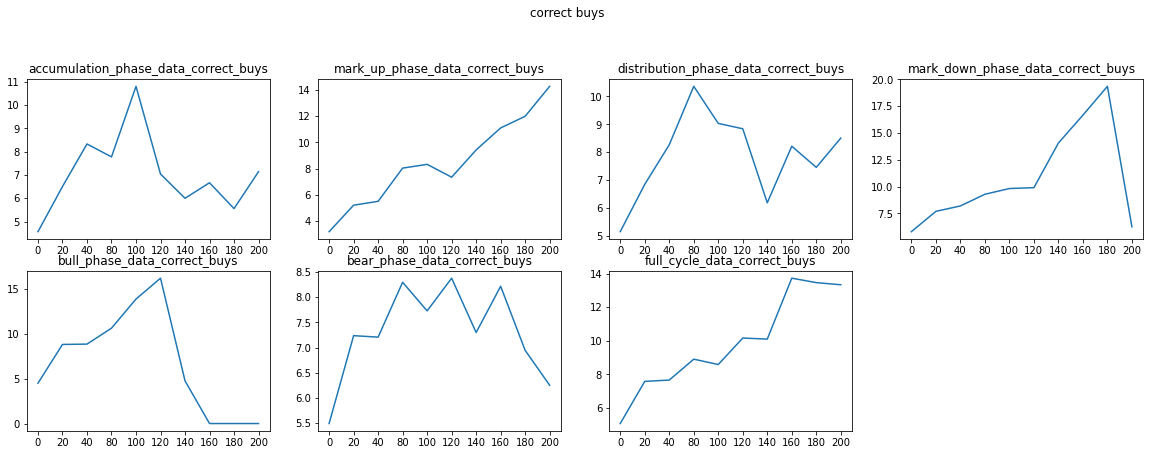

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

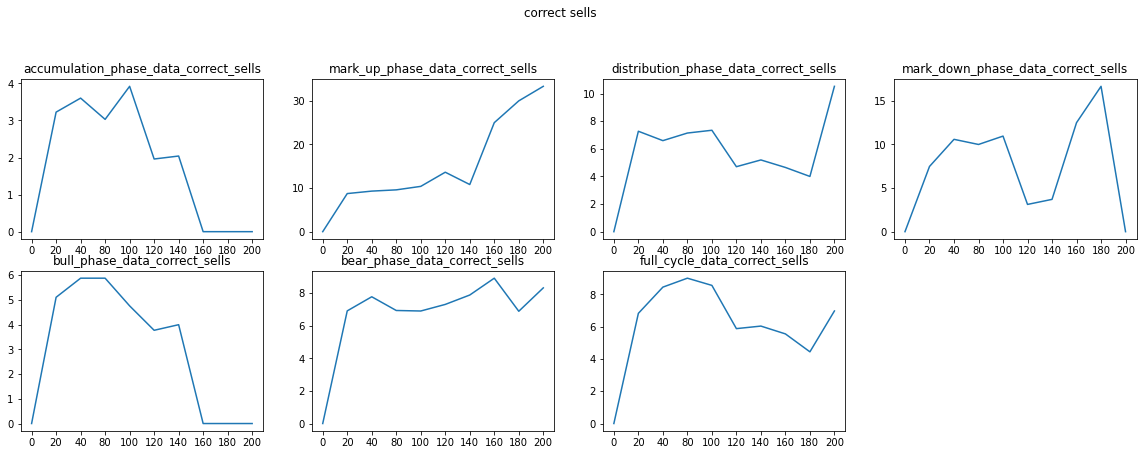

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

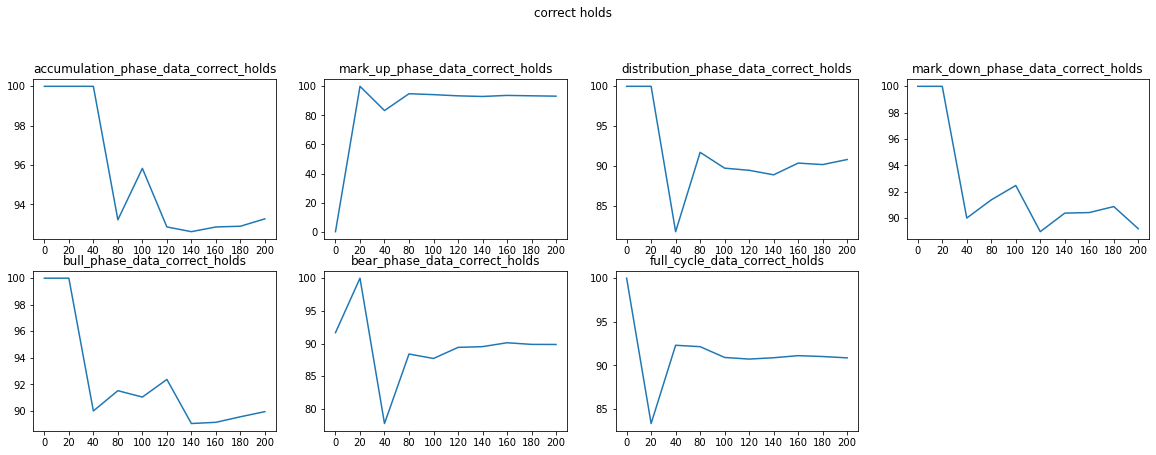

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

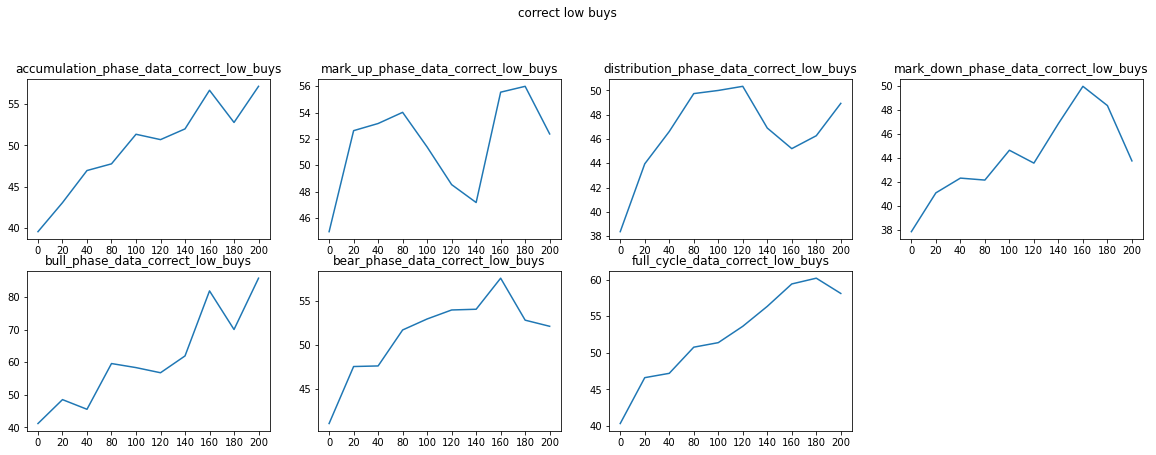

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

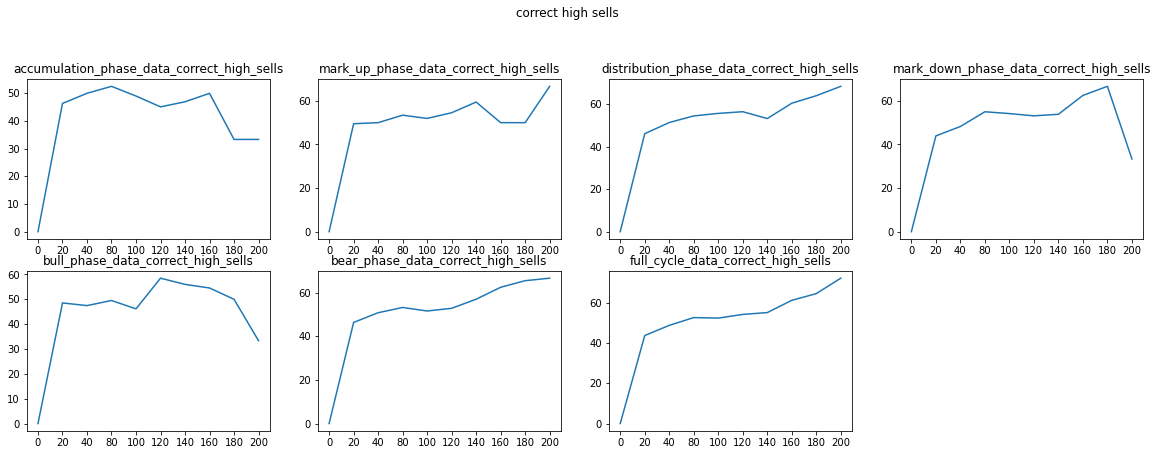

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

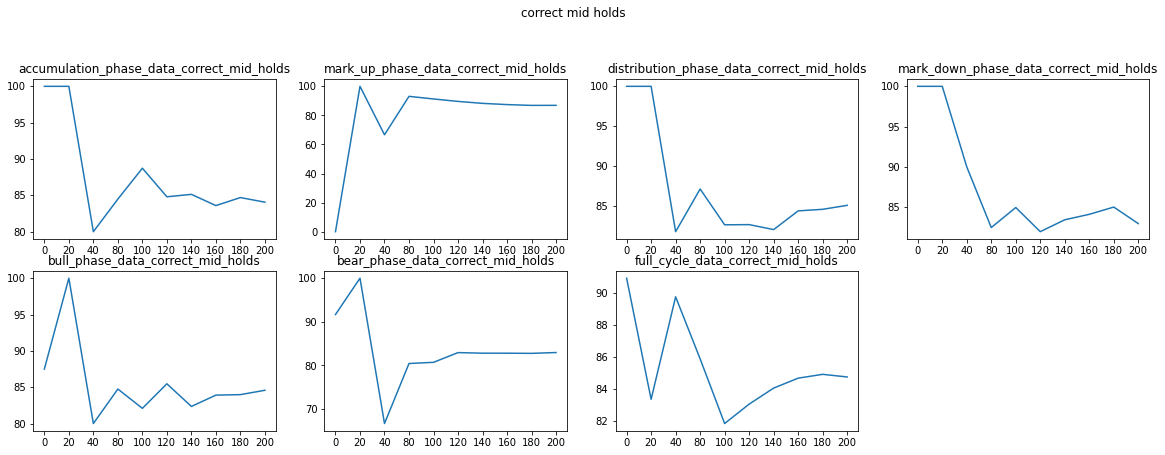

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

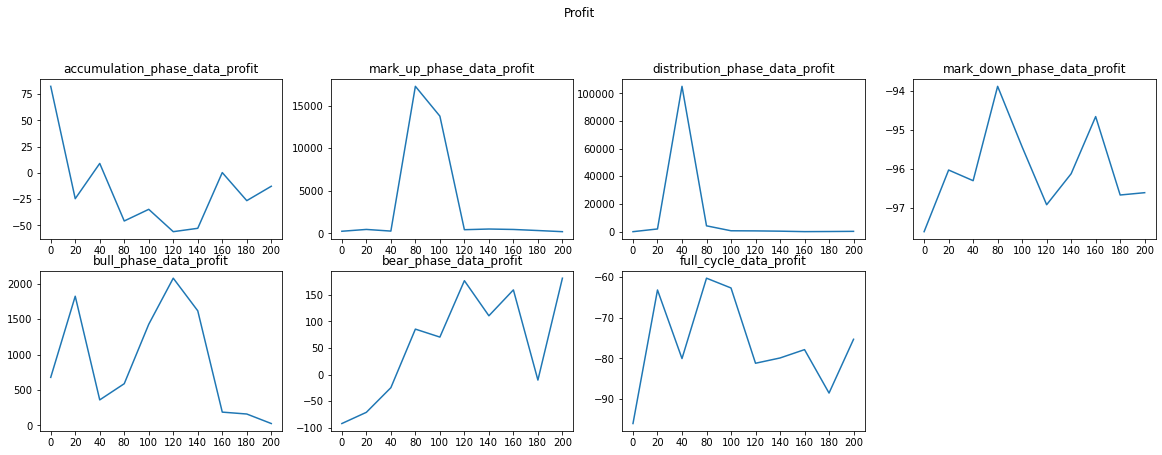

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")